In [30]:
#!pip install git+https://github.com/kornia/kornia

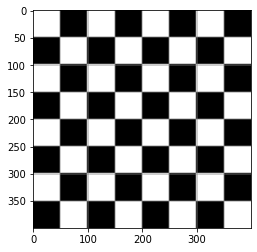

In [41]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
import kornia as K
from skimage.data import checkerboard
import imageio
from copy import deepcopy
from skimage.transform import resize
img = resize(checkerboard(), (400,400), order=0)
plt.imshow(img, cmap='gray')

In [43]:
def create_video_shift_resize(img, factor = 0.25):
    out_fname = f'comparison_{factor}.gif'
    video_writer = imageio.get_writer(out_fname, fps=10)
    h,w = img.shape[:2]
    img_rand = torch.rand(h,w).detach().numpy()
    h_out = int(h*factor)
    w_out = int(w*factor)
    from time import time
    times = [0.,0.,0.,0.]
    for i in range(w//2):
        out_full = np.zeros((h_out*4, w_out))
        img_cur = deepcopy(img_rand)
        img_cur[:, i:w] = deepcopy(img[:, :w-i])
        if True:#mode == 'kornia_resize':
            ii = K.image_to_tensor(img_cur, False).float()
            t=time()
            img_out = K.rescale(ii, (factor, factor))
            times[0]+=time()-t
            out_full[:h_out, :] = deepcopy((255*K.tensor_to_image(img_out)).astype(np.uint8))
            #video_writer.append_data()
        if True:
            #elif mode == 'kornia_resize_iter':
            needed_factor = factor
            rem_factor = needed_factor
            temp_img = deepcopy(K.image_to_tensor(img_cur, False).float())
            
            t=time()
            while rem_factor <= 0.5:
                temp_img =  K.rescale(temp_img, (0.5, 0.5), antialias=False)
                rem_factor = rem_factor / 0.5
            if abs(rem_factor - 1) > 1e-3:
                #print ("non 2x rescale")
                temp_img =  K.rescale(temp_img, (rem_factor, rem_factor), antialias=False)
            img_out = temp_img
            times[1]+=time()-t
            
            out_full[h_out:2*h_out, :] = deepcopy((255*K.tensor_to_image(img_out)).astype(np.uint8))
        if True:#mode == 'kornia_resize_AA':
            ii = K.image_to_tensor(img_cur, False).float()
            t=time()
            img_out = K.rescale(ii, (factor, factor), antialias=True)
            times[2]+=time()-t
            out_full[2*h_out:3*h_out, :] = deepcopy((255*K.tensor_to_image(img_out)).astype(np.uint8))
        if True:#mode == 'kornia_resize_AA':
            img_out = K.image_to_tensor(img_cur, False).float()
            sigmas = (max(1./factor, 1.0), max(1./factor, 1.0))
            t=time()
            # Now kernel size. Good results are for 3 sigma, but that is kind of slow. Pillow uses 1 sigma
            # https://github.com/python-pillow/Pillow/blob/master/src/libImaging/Resample.c#L206
            # But they do it in the 2 passes, which gives better results. Let's try 2 sigmas for now
            ks = int(2.0 * sigmas[0]) + 1, int(2.0 * sigmas[1]) + 1
            if ks[0] % 2 == 0:
                ks = (ks[0]+1, ks[1]+1)
            input_tmp = K.filters.gaussian_blur2d(img_out, ks, sigmas)
            img_out = K.rescale(input_tmp,  (factor, factor), antialias=False)
            times[3]+=time()-t
            
            out_full[3*h_out:4*h_out, :] = deepcopy((255*K.tensor_to_image(img_out)).astype(np.uint8))
        
            #video_writer.append_data((255*K.tensor_to_image(img_out)).astype(np.uint8))

        video_writer.append_data(out_full)
    print (times)
    video_writer.close()
    return    

In [44]:
create_video_shift_resize(img,  0.25)


[0.08110833168029785, 0.2696347236633301, 2.058073043823242, 0.946087121963501]
